In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import snntorch as snn
from snntorch import utils
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
from snntorch import functional

import matplotlib.pyplot as plt
import numpy as np

from trainer import *

from deepr import DeepR

import pickle

import tonic

In [2]:

print(" CSNN Trained on NMNIST")

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Training Parameters
batch_size=256
data_path='./tmp/data/nmnist'
slice_meta_path = "./tmp/NMNIST_sliced/"
num_classes = 10  # MNIST has 10 output classes

frame_time = 10

num_steps = 60 #i.e. the number of frames to feed the SNN

#
transform1 = tonic.transforms.Compose([tonic.transforms.ToFrame(sensor_size=(34,34,2),n_time_bins=num_steps),lambda x: x.astype(np.float32)]) 

nmnist_train = tonic.datasets.NMNIST(data_path, train=True)
nmnist_test = tonic.datasets.NMNIST(data_path, train=False)


train_nmnist_mem = tonic.MemoryCachedDataset(nmnist_train)
test_nmnist_mem = tonic.MemoryCachedDataset(nmnist_test)

slicer = tonic.slicers.SliceByTime(60*frame_time*1000,59*frame_time*1000,False)
#59 allow an overlap such that we start a new slice at every possible frame.
#however,
 
#NOTE careful , you will need to regenerate the metadata after changing parameters, takes about 30 seconds to generate the slices
#slice our dataset into a samples of frame groups - we do not need an entire sample at once
train_sliced_nmnist = tonic.SlicedDataset(train_nmnist_mem,transform=transform1,slicer=slicer,)#metadata_path=slice_meta_path+"train/")
test_sliced_nmnist = tonic.SlicedDataset(test_nmnist_mem,transform=transform1,slicer=slicer,)#metadata_path=slice_meta_path+"test/")

#dont bother using disk cached dataset, it doesnt speed things up
#dont bother changing the overlap window either... 
#yes,dataloading is the slowest part of training


train_sampler = torch.utils.data.RandomSampler(train_nmnist_mem, generator=gtrain,replacement=False)
test_sampler = torch.utils.data.RandomSampler(test_nmnist_mem, generator=gtest,replacement=False)

train_loader = DataLoader(nmnist_train,shuffle=False,batch_size=batch_size,drop_last=False,pin_memory=True,sampler=train_sampler,num_workers=1)
test_loader = DataLoader(nmnist_test,shuffle=False,batch_size=batch_size,drop_last=False,pin_memory=True,sampler=test_sampler,num_workers=1)

print("Train batches:",len(train_loader))
print("Test batches:",len(test_loader))

 CSNN Trained on NMNIST
Using device: cuda
Train batches: 235
Test batches: 40


Useful to know what a convolutional layers output dimension is given by $n_{out}=\frac{n_{in}+2p-k}{s}+1$, 
with default padding=0 stride=1 $n_{out}=n_{in}-k+1$.
For max pool with defaults, $\lfloor\frac{n}{2}\rfloor$.

In [3]:

#if you want to create more samples you can change the overlap
a = next(iter(test_loader))
print(a[0].shape)

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/UnladenCoconut/git/arch-venv/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/UnladenCoconut/git/arch-venv/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/UnladenCoconut/git/arch-venv/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 277, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/UnladenCoconut/git/arch-venv/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 144, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/UnladenCoconut/git/arch-venv/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 144, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/UnladenCoconut/git/arch-venv/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 121, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/UnladenCoconut/git/arch-venv/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 183, in collate_numpy_array_fn
    return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/UnladenCoconut/git/arch-venv/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 183, in <listcomp>
    return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
                    ^^^^^^^^^^^^^^^^^^
TypeError: can't convert np.ndarray of type numpy.void. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.


In [ ]:
################ MNIST Model ##############################################################

# layer parameters
num_steps = 16  # for spike encoding
beta = 0.95 #leak rate
lr=5e-3

spike_grad1 = surrogate.atan() 

class Net(nn.Module):

    def __init__(self,c = None):
        super().__init__()

        self.loss = functional.ce_count_loss()
        self.accuracy_metric = functional.accuracy_rate

        #initialise neuron connections
        self.layers = nn.ModuleList([
            nn.Conv2d(1, 12, 5), #28 square -> 24 square
            nn.MaxPool2d(2), # 12 square
            nn.Conv2d(12,64,5), # 8 square
            nn.MaxPool2d(2), #4 square
            nn.Linear(64*4*4,10)
        ])

        # initialize neurons
        self.neurons = nn.ModuleList([
            snn.Leaky(beta=beta,spike_grad=spike_grad1),
            snn.Leaky(beta=beta,spike_grad=spike_grad1),
            snn.Leaky(beta=beta,spike_grad=spike_grad1)
        ])

        self.to(device)

        #pytorch creates the tensors to represent the network layout and weights for each layer; snntorch provides the model that operates on the entire tensor (at each layer).
        if c is not None:
            self.deepr = DeepR(self.layers,lr,[0,2,4],connectivity=c,device=device)
  
    def forward(self,x): #x is input data, assume is batched

        #spike encoding at input layer
        x_spk = spikegen.rate(x,num_steps=num_steps) 
        
        # Initialize hidden states
        mem1 = self.neurons[0].init_leaky()
        mem2 = self.neurons[1].init_leaky()
        mem3 = self.neurons[2].init_leaky()
        
        # record spike outputs and membrane potentials
        spk3_rec = []

        for step in range(num_steps):
            x = x_spk[step] #for encoded input
            cur1 = self.layers[1](self.layers[0](x))

            spk1, mem1 = self.neurons[0](cur1, mem1)

            cur2 = self.layers[3](self.layers[2](spk1))
            spk2, mem2 = self.neurons[1](cur2, mem2)

            cur3 = self.layers[4](spk2.view(spk2.size()[0],-1)) #flatten!
            spk3, mem3 = self.neurons[2](cur3, mem3)

            spk3_rec.append(spk3)

        return torch.stack(spk3_rec, dim=0)
    
###################################################################################



In [ ]:
#with and without deepr
model_path = "./models/SNN_CNN_MNIST.pt"
net = Net()
optimiser = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=0)
gen_reset() #reset the PRNG generators for the random samplers so we consistently get the same sequence of samples for each experiment run
net = trainer(net,train_loader=train_loader,valid_loader=test_loader,model_path=model_path,optimiser=optimiser,epochs=3,deepr=False,device=device)
gen_reset()
baseline_accuracy = test_stats(net,test_loader=test_loader,device=device)
print("----")

connectivities = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01]

accuracies = []

for c in connectivities:
    model_path = "./models/SNN_CNN_MNIST_conn"+str(c)+".pt"
    net = Net(c)
    optimiser = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=0)
    gen_reset()
    net = trainer(net,train_loader=train_loader,valid_loader=test_loader,model_path=model_path,optimiser=optimiser,epochs=3,deepr=True,device=device)
    gen_reset()
    a = test_stats(net,test_loader=test_loader,device=device)
    accuracies.append(a)

with open("./pickles/SNN_CNN_MNIST_baseline", "wb") as f:
    pickle.dump(baseline_accuracy,f)

with open("./pickles/SNN_CNN_MNIST_deepr_accuracies", "wb") as f:
    pickle.dump(accuracies,f)

Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.12 GiB. GPU 0 has a total capacity of 5.79 GiB of which 282.12 MiB is free. Process 76821 has 1006.00 MiB memory in use. Including non-PyTorch memory, this process has 4.45 GiB memory in use. Of the allocated memory 4.37 GiB is allocated by PyTorch, and 1.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

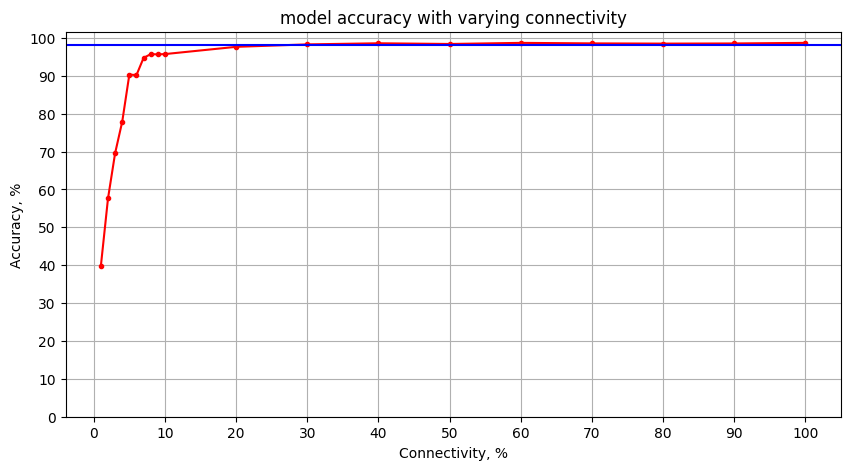

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot([c*100 for c in connectivities],[a*100 for a in accuracies],'.r-')
plt.axhline(y = baseline_accuracy*100, color = 'b', linestyle = '-')
plt.title("model accuracy with varying connectivity")
plt.xlabel("Connectivity, %")
plt.ylabel("Accuracy, %")
plt.xticks(range(0,101,10))
plt.yticks(range(0,101,10))
plt.grid(True)
plt.show()